In [1]:
#import de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
# Paso 3: Identificación del tipo de variables

# Cargar dataset
df = pd.read_csv("../datos_simulados/datos_final.csv")

# Clasificación de variables
variables_categoricas = [
    'Clase', 'Pieza', 'Superficie_1', 'Superficie_2',
    'Estado_cavidad', 'Tecnica', 'Tipo_resina', 'Ajuste_margen'
]

variables_numericas = [
    'Tamanio_cavidad_mm', 'Indice_contraccion_%',
    'Peso_resina_inicial_mg', 'Peso_sobrante_mg', 'Margen_cavo_mm'
]

# Mostrar resumen
print("Variables categóricas:", variables_categoricas)
print("Variables numéricas:", variables_numericas)

# Vista previa
df.head()


Variables categóricas: ['Clase', 'Pieza', 'Superficie_1', 'Superficie_2', 'Estado_cavidad', 'Tecnica', 'Tipo_resina', 'Ajuste_margen']
Variables numéricas: ['Tamanio_cavidad_mm', 'Indice_contraccion_%', 'Peso_resina_inicial_mg', 'Peso_sobrante_mg', 'Margen_cavo_mm']


,Clase,Pieza,Superficie_1,Superficie_2,Tamanio_cavidad_mm,Estado_cavidad,Tecnica,Indice_contraccion_%,Peso_resina_inicial_mg,Peso_sobrante_mg,Margen_cavo_mm,Ajuste_margen
0,VI,23,Incisal,ninguna,2.47,limpia,Estratificacion,1.30,56.46,10.69,2.64,Sobreobturado
1,I,30,Oclusal,ninguna,4.62,limpia,Bulk,3.70,147.42,4.67,4.58,Equiobturado
2,II,17,Distal,ninguna,5.51,limpia,Bulk,1.29,104.42,16.63,5.75,Sobreobturado
3,I,2,Lingual,ninguna,1.64,limpia,Estratificacion,3.66,68.54,4.16,1.90,Sobreobturado
4,III,10,Mesial,ninguna,4.23,limpia,Bulk,2.30,96.63,5.67,3.88,Subobturado


In [3]:
# Paso 4a: Estadística descriptiva y distribución de variables

# Estadística descriptiva para variables numéricas
df.describe()

,Pieza,Tamanio_cavidad_mm,Indice_contraccion_%,Peso_resina_inicial_mg,Peso_sobrante_mg,Margen_cavo_mm
count,18600.000000,18600.000000,18600.000000,18600.000000,18600.000000,18600.000000
mean,16.500000,3.243214,1.992595,87.318012,7.565516,3.238730
std,9.136755,1.231408,0.950633,25.875941,4.540666,1.329417
min,1.000000,1.000000,0.500000,44.800000,0.410000,0.100000
25%,8.750000,2.210000,1.250000,66.560000,4.270000,2.190000
50%,16.500000,3.240000,1.750000,83.410000,6.850000,3.270000
75%,24.250000,4.220000,2.420000,105.332500,10.060000,4.240000
max,32.000000,6.000000,4.250000,159.550000,29.540000,6.970000


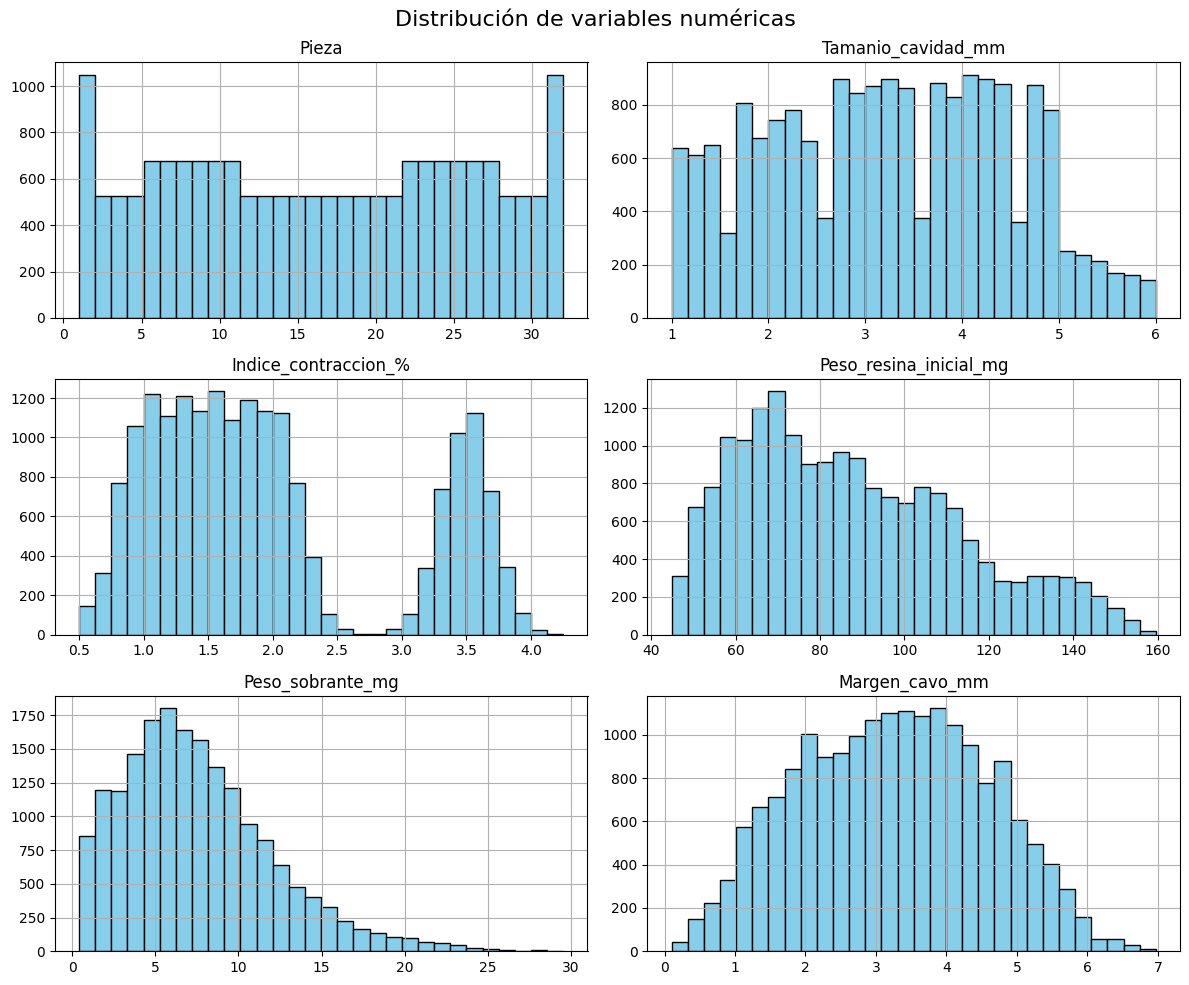

In [4]:
df.hist(
    figsize=(12, 10),
    bins=30,
    color='skyblue',
    edgecolor='black'
)
plt.suptitle("Distribución de variables numéricas", fontsize=16)
plt.tight_layout()
plt.show()


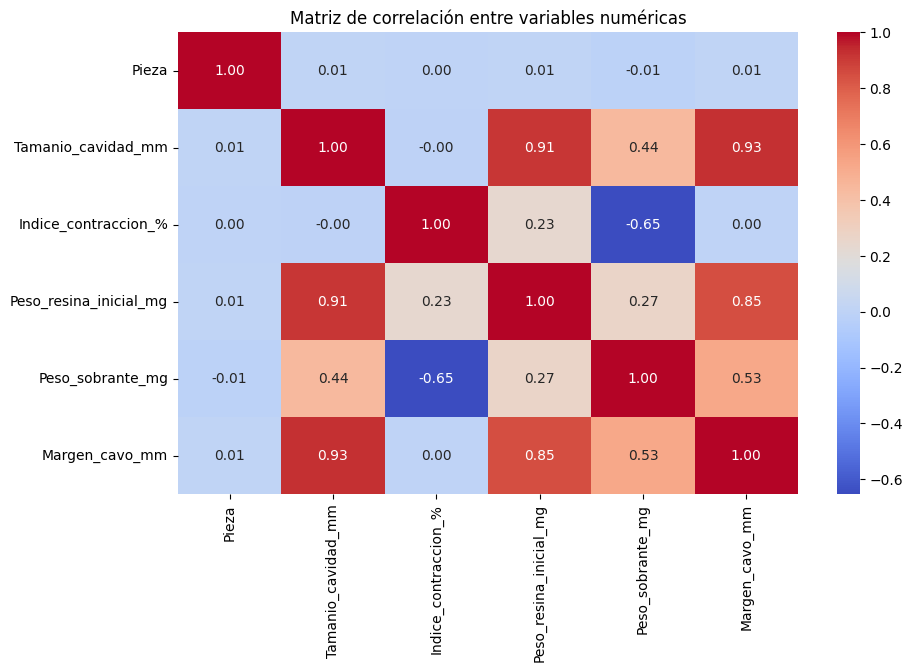

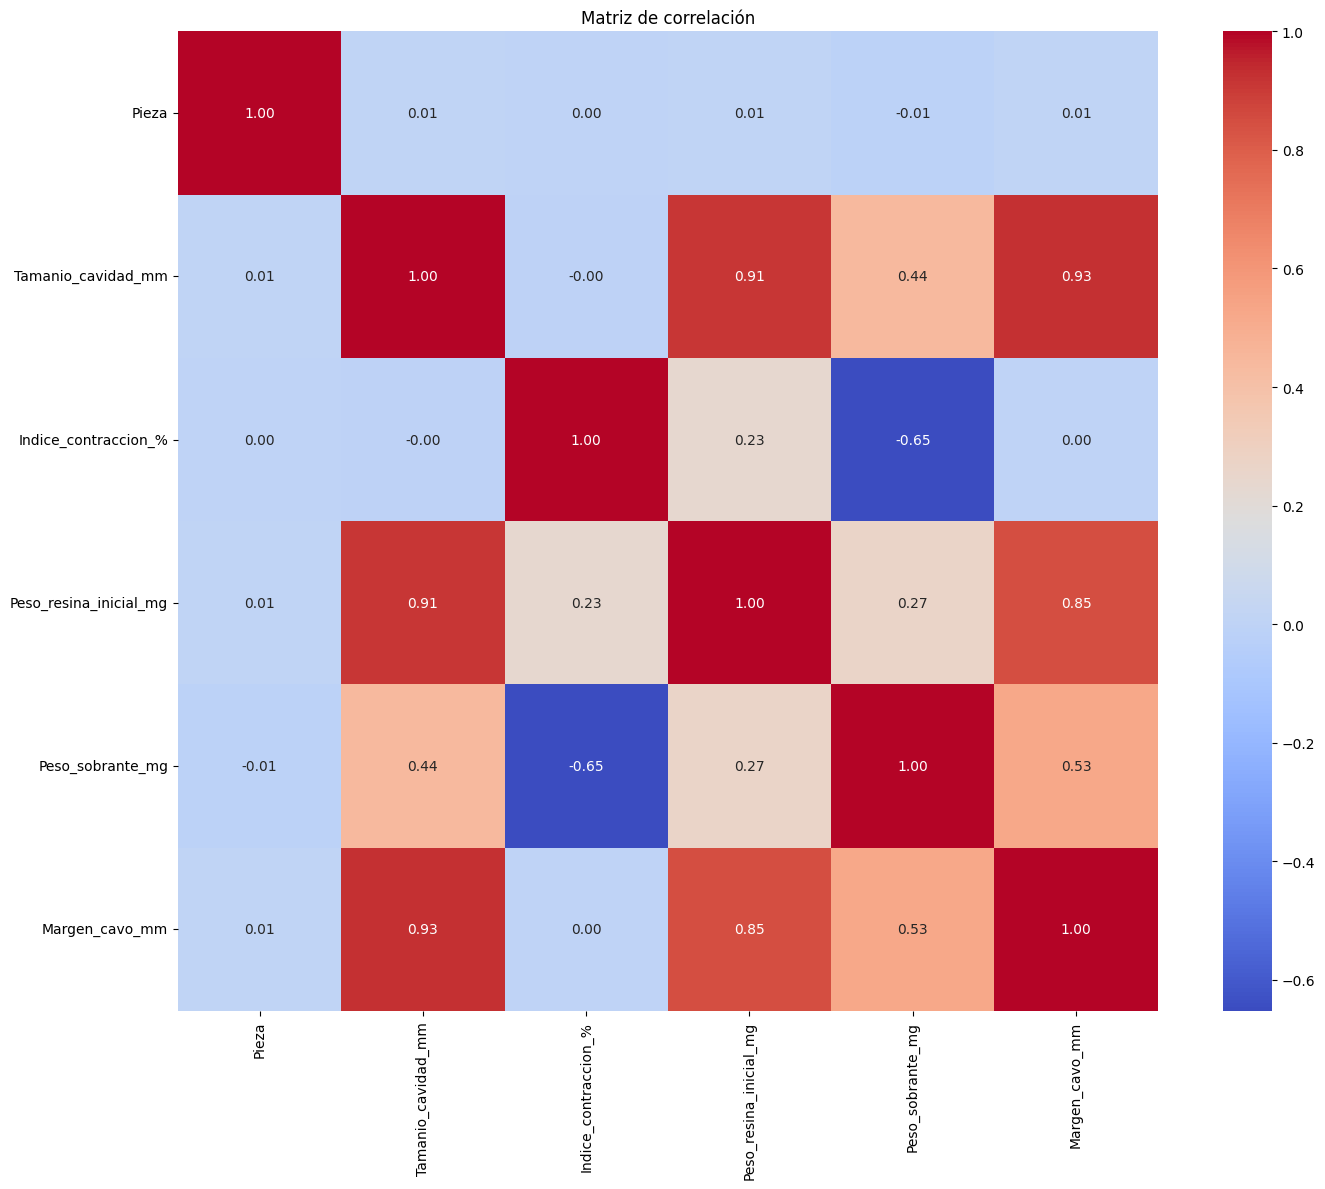

In [5]:
# Paso 4b: Correlación de variables numéricas

# Mapa de calor de correlaciones
plt.figure(figsize=(10, 6))

correlacion = df.corr(numeric_only=True)
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas")
plt.show()


plt.figure(figsize=(15, 12))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()

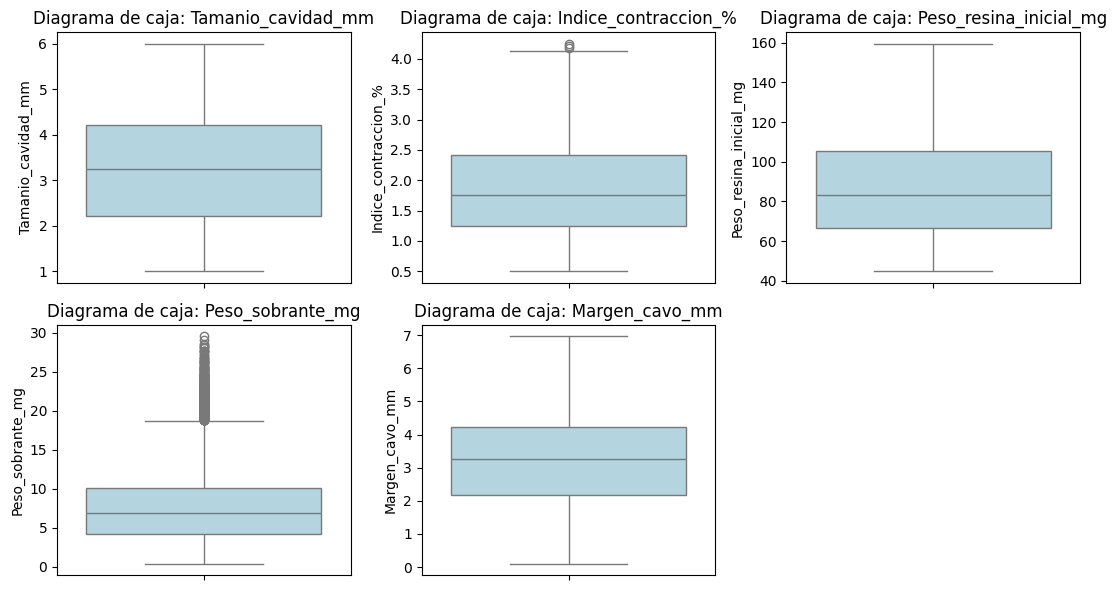

In [6]:
# Paso 4c: Diagramas de caja para detectar outliers

plt.figure(figsize=(11, 6))
for i, col in enumerate(variables_numericas):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(f'Diagrama de caja: {col}')
    plt.tight_layout()
plt.show()


In [7]:
# Paso 5c: Verificación y eliminación de duplicados exactos

# Contar duplicados
duplicados = df.duplicated().sum()
print(f"Filas duplicadas exactas: {duplicados}")

# Eliminar si existen
if duplicados > 0:
    df = df.drop_duplicates()


Filas duplicadas exactas: 0


In [8]:
# Paso 5b: Tratamiento de outliers

# Solo se tratarán los outliers en 'Peso_sobrante_mg'
# porque fue la única variable que presentó valores atípicos evidentes en los diagramas de caja.
# Las demás variables muestran distribuciones esperadas o sin puntos extremos significativos.

# Calcular límites para detección de outliers (IQR)
q1 = df['Peso_sobrante_mg'].quantile(0.25)
q3 = df['Peso_sobrante_mg'].quantile(0.75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

# Contar antes de filtrar
filas_antes = df.shape[0]

# Filtrar outliers
df = df[(df['Peso_sobrante_mg'] >= limite_inferior) & (df['Peso_sobrante_mg'] <= limite_superior)]

# Contar después de filtrar
filas_despues = df.shape[0]
print(f"Filas eliminadas por outliers en 'Peso_sobrante_mg': {filas_antes - filas_despues}")


Filas eliminadas por outliers en 'Peso_sobrante_mg': 458


In [9]:
# Paso 6a: Validar que no existan datos nulos

valores_nulos = df.isnull().sum()
print("Valores nulos por columna:")
print(valores_nulos)

print("\nTotal de celdas con valores nulos:", valores_nulos.sum())


Valores nulos por columna:
Clase                     0
Pieza                     0
Superficie_1              0
Superficie_2              0
Tamanio_cavidad_mm        0
Estado_cavidad            0
Tecnica                   0
Indice_contraccion_%      0
Peso_resina_inicial_mg    0
Peso_sobrante_mg          0
Margen_cavo_mm            0
Ajuste_margen             0
dtype: int64

Total de celdas con valores nulos: 0


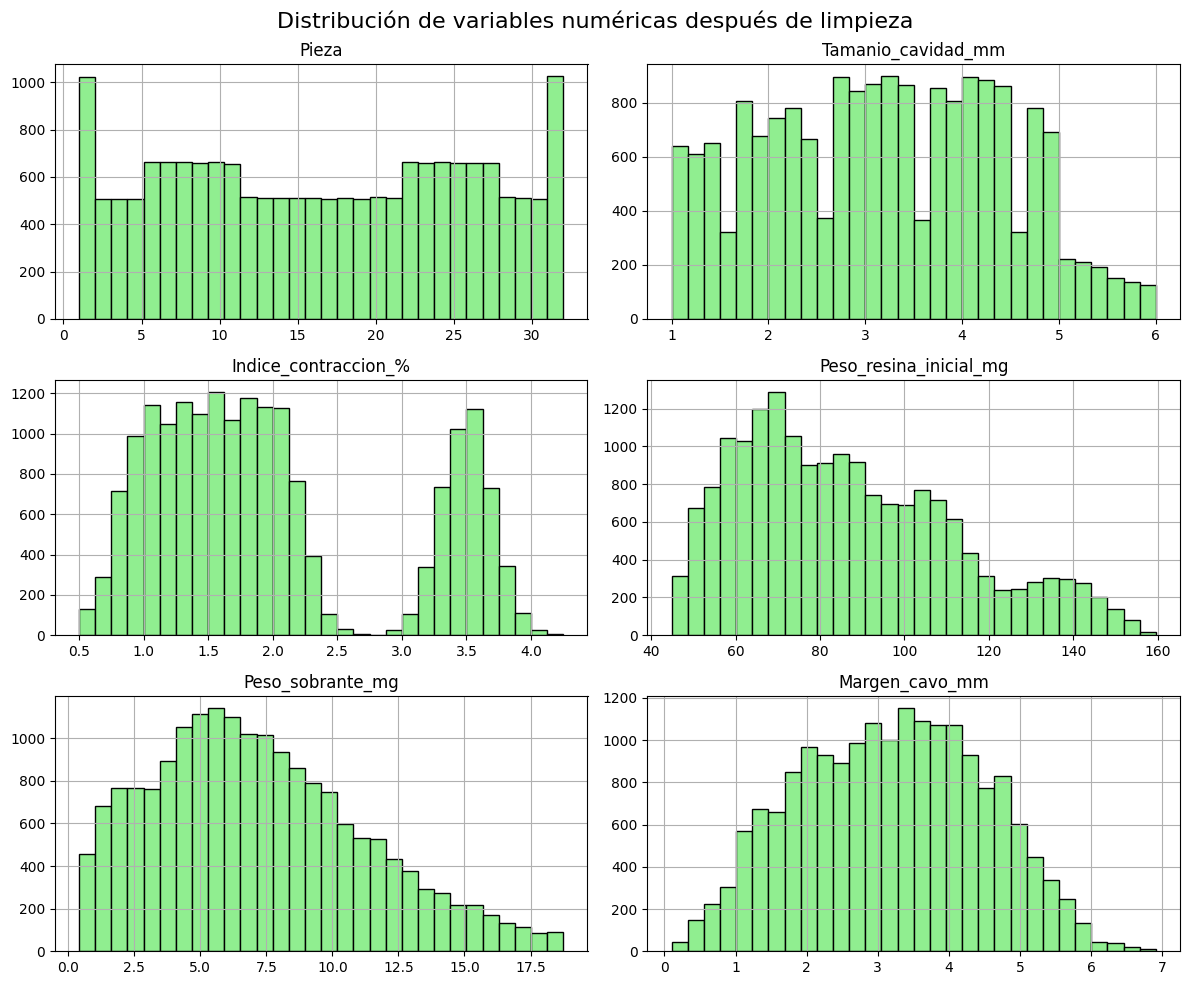

In [10]:
# Paso 6b: Verificar efecto de las transformaciones aplicadas

# Histograma actualizado para ver si hay cambios en las distribuciones
df.hist(
    figsize=(12, 10),
    bins=30,
    color='lightgreen',
    edgecolor='black'
)
plt.suptitle("Distribución de variables numéricas después de limpieza", fontsize=16)
plt.tight_layout()
plt.show()


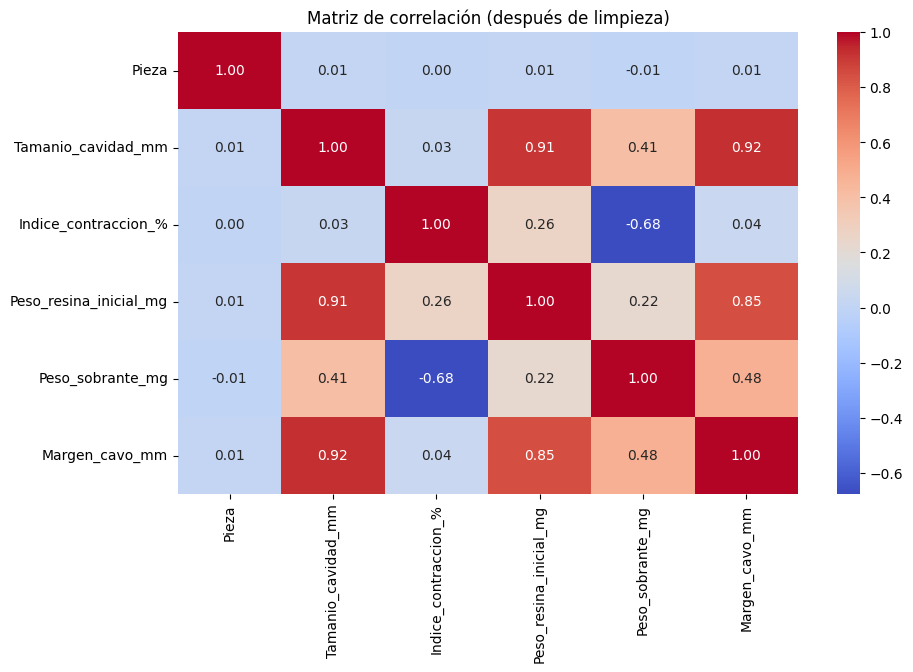

In [11]:
# Paso 6c: Identificar si surgieron nuevos patrones o problemas

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación (después de limpieza)")
plt.show()


In [12]:
# Paso 6e: Cálculo de diferencias en correlaciones (pre/post tratamiento)

# (1) Releer el dataset original sin transformaciones
df_original = pd.read_csv("../datos_simulados/datos_final.csv")

# (2) Calcular matriz de correlación original
corr_original = df_original.corr(numeric_only=True)

# (3) Calcular matriz de correlación actual (después del tratamiento)
corr_actual = df.corr(numeric_only=True)

# (4) Comparar ambas
diferencia = (corr_actual - corr_original).abs()

print("Diferencia absoluta entre correlaciones pre/post tratamiento:")
print(diferencia)


Diferencia absoluta entre correlaciones pre/post tratamiento:
                           Pieza  Tamanio_cavidad_mm  Indice_contraccion_%  \
Pieza                   0.000000            0.002198              0.001009   
Tamanio_cavidad_mm      0.002198            0.000000              0.029100   
Indice_contraccion_%    0.001009            0.029100              0.000000   
Peso_resina_inicial_mg  0.002254            0.000446              0.028048   
Peso_sobrante_mg        0.001975            0.037639              0.024474   
Margen_cavo_mm          0.002774            0.002435              0.037309   

                        Peso_resina_inicial_mg  Peso_sobrante_mg  \
Pieza                                 0.002254          0.001975   
Tamanio_cavidad_mm                    0.000446          0.037639   
Indice_contraccion_%                  0.028048          0.024474   
Peso_resina_inicial_mg                0.000000          0.046362   
Peso_sobrante_mg                      0.046362     

In [13]:
# Paso 7: Entrenamiento del modelo de regresión lineal

# Variables predictoras y variable objetivo
X = df.drop(columns=['Peso_resina_inicial_mg', 'Peso_sobrante_mg'])  # quitamos también la sobrante
y = df['Peso_resina_inicial_mg']

# Codificar variables categóricas (One-Hot)
X = pd.get_dummies(X, drop_first=True)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo
modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)

# Predicciones
y_pred = modelo.predict(X_test_scaled)

# Métricas
mse  = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.2f}")


RMSE: 8.28
MAE : 6.54
R²  : 0.90


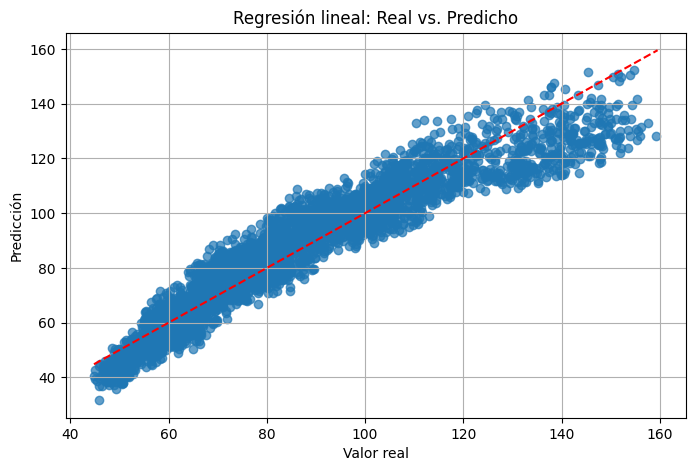

In [14]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Regresión lineal: Real vs. Predicho")
plt.grid(True)
plt.show()